#Task 1
##Review the paper, and any related resources to learn how to implement quantum Galton boards. Prepare a summary of your understanding in a well structured 2-pager document.

Reading list:Universal Statistical Simulator,  Mark Carney, Ben Varcoe, [link text](https://arxiv.org/abs/2202.01735)


Summary: [link text](https://github.com/triutari2305/project1/blob/main/Summary__Universal_Statistical_Simulator.pdf)

#Task 2
##Using the 1- and 2-layer Galton Box code as a starting point, write a general algorithm that generates a circuit for any number of layers. Run and verify that the output is a Gaussian distribution. You may use any quantum SDK and platform for your implementation.

In [1]:
!pip install qiskit qiskit-aer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.9 MB/s eta 0:00:00


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
import numpy as np
import math

In [3]:
def cswap(qc, control, target1, target2):
    qc.cx(target2, target1)
    qc.ccx(control, target1, target2)
    qc.cx(target2, target1)

In [4]:
def build_qgb_circuit(n_layers, measure=False):
    coin = QuantumRegister(1, "coin")
    pos = QuantumRegister(n_layers+1, "pos")
    creg = ClassicalRegister(n_layers+1, "c") if measure else None
    qc = QuantumCircuit(coin, pos, creg) if measure else QuantumCircuit(coin, pos)

    #position at pos[0] = |1>
    qc.x(pos[0])

    for layer in range(n_layers):
        qc.h(coin[0])
        for p in range(n_layers-layer):
            cswap(qc, coin[0], pos[p], pos[p+1])

    if measure:
        qc.measure(pos, creg)

    return qc

In [5]:
def binomial_distribution(n):
    return np.array([math.comb(n, k) / 2**n for k in range(n+1)])

In [6]:
def gaussian_approx(n):
    mu = n/2
    sigma = math.sqrt(n)/2
    xs = np.arange(0, n+1)
    norm = 1/(sigma*math.sqrt(2*math.pi))
    gauss = norm * np.exp(-(xs - mu)**2 / (2*sigma**2))
    return gauss / gauss.sum()

In [7]:
def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(np.array(p) - np.array(q)))

In [8]:
#Simulations
def simulate_statevector(n):
    qc = build_qgb_circuit(n, measure=False)
    backend = Aer.get_backend("statevector_simulator")
    result = backend.run(transpile(qc, backend)).result()
    statevector = result.get_statevector(qc)
    probs = np.zeros(n+1)
    #hitung distribusi posisi (abaikan coin qubit)
    for i, amp in enumerate(statevector):
        bitstring = format(i, f"0{n+2}b")  #1 coin + (n+1) position qubits
        pos_bits = bitstring[1:]  #buang coin
        position_index = pos_bits[::-1].find("1")
        if position_index != -1:
            probs[position_index] += abs(amp)**2
    return probs

In [9]:
def simulate_qasm(n, shots=8192):
    qc = build_qgb_circuit(n, measure=True)
    backend = Aer.get_backend("qasm_simulator")
    result = backend.run(transpile(qc, backend), shots=shots).result()
    counts = result.get_counts()
    probs = np.zeros(n+1)
    for bitstring, count in counts.items():
        pos_bits = bitstring.split(" ")[0]  #ambil register posisi
        position_index = pos_bits[::-1].find("1")
        if position_index != -1:
            probs[position_index] += count / shots
    return probs, counts

In [10]:
#Example usage & verification
if __name__ == "__main__":
    n = 6
    probs_sv = simulate_statevector(n)                 #noiseless exact
    probs_qasm, counts = simulate_qasm(n, shots=8192)  #sampling (noiseless simulator)

    binom = binomial_distribution(n)
    gauss = gaussian_approx(n)
    tvd_bin_sv = total_variation_distance(probs_sv, binom)
    tvd_gauss_sv = total_variation_distance(probs_sv, gauss)

    print(f"n={n} (statevector) TVD to binomial = {tvd_bin_sv:.6f}, TVD to gaussian = {tvd_gauss_sv:.6f}")
    print("Position probs (statevector):")
    for i, p in enumerate(probs_sv):
        print(f" pos {i:2d}: {p:.6f}")

/tmp/ipython-input-496199271.py:9: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, amp in enumerate(statevector):


n=6 (statevector) TVD to binomial = 0.765625, TVD to gaussian = 0.764979
Position probs (statevector):
 pos  0: 0.656250
 pos  1: 0.015625
 pos  2: 0.000000
 pos  3: 0.015625
 pos  4: 0.000000
 pos  5: 0.062500
 pos  6: 0.000000


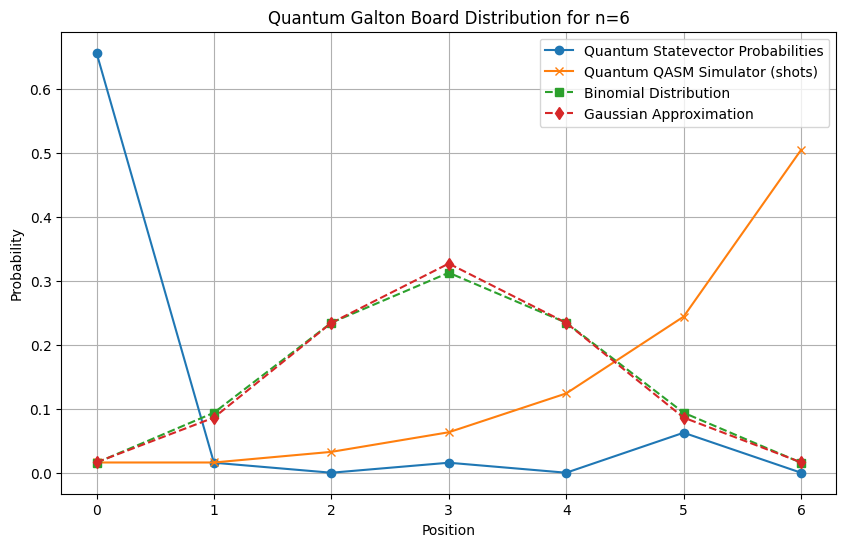

In [11]:
import matplotlib.pyplot as plt

#Plotting the distributions
positions = np.arange(n + 1)

plt.figure(figsize=(10,6))
plt.plot(positions, probs_sv, 'o-', label='Quantum Statevector Probabilities')
plt.plot(positions, probs_qasm, 'x-', label='Quantum QASM Simulator (shots)')
plt.plot(positions, binom, 's--', label='Binomial Distribution')
plt.plot(positions, gauss, 'd--', label='Gaussian Approximation')

plt.title(f'Quantum Galton Board Distribution for n={n}')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

#Task 3
## Modify the function so that it obtains a different target distribution. Use a noiseless all-to-all sampler:

### a. Exponential distribution

In [12]:
def build_qgb_circuit(n_layers, measure=False, bias_angle=None):
    coin = QuantumRegister(1, "coin")
    pos = QuantumRegister(n_layers+1, "pos")
    creg = ClassicalRegister(n_layers+1, "c") if measure else None
    qc = QuantumCircuit(coin, pos, creg) if measure else QuantumCircuit(coin, pos)

    qc.x(pos[0])  #Initialize position at pos[0] = |1>

    for layer in range(n_layers):
        if bias_angle is None:
            qc.h(coin[0])  #balanced coin toss (Hadamard)
        else:
            qc.rx(bias_angle, coin[0])  #biased coin toss with RX rotation
        for p in range(n_layers - layer):
            cswap(qc, coin[0], pos[p], pos[p + 1])

    if measure:
        qc.measure(pos, creg)

    return qc

In [13]:
n = 6
bias_angle = 0.3  #smaller angle ~ less bias

probs_biased = simulate_statevector(n)

def simulate_statevector_biased(n, bias_angle):
    qc = build_qgb_circuit(n, measure=False, bias_angle=bias_angle)
    backend = Aer.get_backend("statevector_simulator")
    result = backend.run(transpile(qc, backend)).result()
    statevector = result.get_statevector(qc)
    probs = np.zeros(n + 1)
    for i, amp in enumerate(statevector):
        bitstring = format(i, f"0{n + 2}b")
        pos_bits = bitstring[1:]
        position_index = pos_bits[::-1].find("1")
        if position_index != -1:
            probs[position_index] += abs(amp) ** 2
    return probs

probs_biased = simulate_statevector_biased(n, bias_angle=0.3)


/tmp/ipython-input-496199271.py:9: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, amp in enumerate(statevector):
/tmp/ipython-input-2400194000.py:12: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, amp in enumerate(statevector):


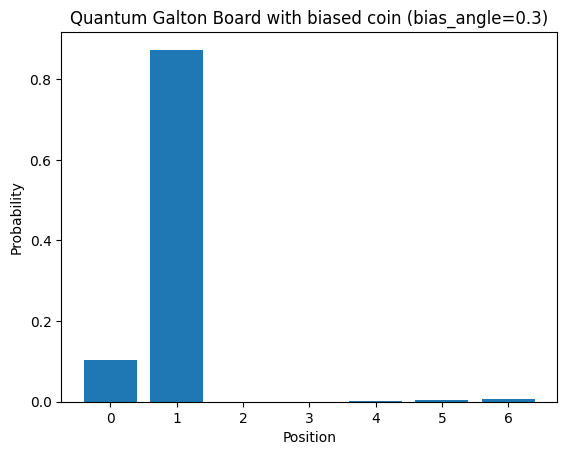

In [14]:
positions = np.arange(n + 1)
plt.bar(positions, probs_biased)
plt.title(f'Quantum Galton Board with biased coin (bias_angle={bias_angle})')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.show()


###Hadamard quantum walk

In [37]:
def controlled_increment(qc, control_qubit, target_register):
    n = len(target_register)
    qc.mcx([control_qubit], target_register[0])  #CNOT controlled on control_qubit

    for i in range(1, n):
        controls = [control_qubit] + target_register[:i]
        qc.mcx(controls, target_register[i])

In [38]:
def controlled_decrement(qc, control_qubit, target_register):
    n = len(target_register)

    #Invert target register
    for q in target_register:
        qc.x(q)

    #Controlled increment on inverted bits
    controlled_increment(qc, control_qubit, target_register)

    #Invert target register back
    for q in target_register:
        qc.x(q)

In [39]:
def build_hadamard_quantum_walk_manual(n_steps, measure=False):
    n_pos_qubits = math.ceil(math.log2(2 * n_steps + 1))
    coin = QuantumRegister(1, "coin")
    pos = QuantumRegister(n_pos_qubits, "pos")
    creg = ClassicalRegister(n_pos_qubits, "c") if measure else None
    qc = QuantumCircuit(coin, pos, creg) if measure else QuantumCircuit(coin, pos)

    #Init position at middle
    init_pos = n_steps
    for i in range(n_pos_qubits):
        if (init_pos >> i) & 1:
            qc.x(pos[i])

    for _ in range(n_steps):
        qc.h(coin[0])  #Hadamard coin toss

        #Controlled increment if coin=1
        controlled_increment(qc, coin[0], pos)

        #Controlled decrement if coin=0
        qc.x(coin[0])
        controlled_decrement(qc, coin[0], pos)
        qc.x(coin[0])

    if measure:
        qc.measure(pos, creg)

    return qc

In [40]:
def simulate_statevector_hqw_manual(n_steps):
    qc = build_hadamard_quantum_walk_manual(n_steps, measure=False)
    backend = Aer.get_backend("statevector_simulator")
    result = backend.run(transpile(qc, backend)).result()
    statevector = result.get_statevector(qc)

    n_pos_qubits = math.ceil(math.log2(2 * n_steps + 1))
    probs = np.zeros(2 * n_steps + 1)

    for i, amp in enumerate(statevector):
        bitstring = format(i, f"0{1 + n_pos_qubits}b")
        pos_bits = bitstring[1:]  # ignore coin
        pos_index = int(pos_bits[::-1], 2)
        if 0 <= pos_index < len(probs):
            probs[pos_index] += abs(amp) ** 2

    return probs

/tmp/ipython-input-1118944027.py:10: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i, amp in enumerate(statevector):


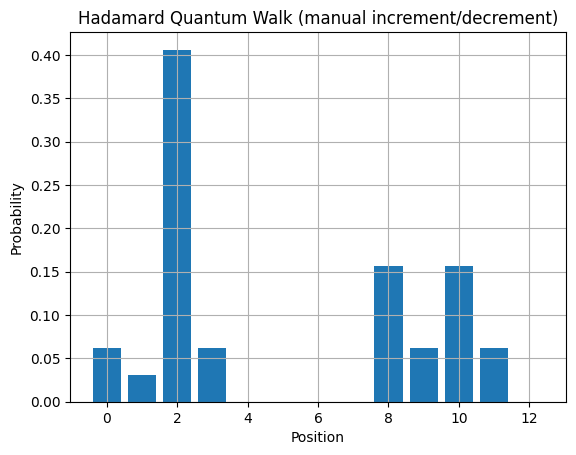

In [42]:
n_steps = 6
probs = simulate_statevector_hqw_manual(n_steps)

plt.bar(np.arange(2*n_steps+1), probs)
plt.title("Hadamard Quantum Walk (manual increment/decrement)")
plt.xlabel("Position")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

#Task 4
##Using a noise model of real hardware, come up with an optimized implementation of this problem for the previous distributions. The challenge is to maximize the accuracy and number of board layers. You may use any quantum hardware noise model for your simulations

In [20]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
import random
import time

In [21]:
noise_model = NoiseModel()

#depolarizing error
error_1 = depolarizing_error(0.001, 1)
error_2 = depolarizing_error(0.01, 2)

noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

print("Noise model custom ready to use")

Noise model custom ready to use


In [22]:
def evaluate_circuit_noise_qasm(circ, noise_model, shots=4000, optimization_level=1,
                                initial_layout=None, routing_method="sabre", backend_name="qasm_simulator"):
    backend = Aer.get_backend(backend_name)
    try:
        tcirc = transpile(circ, backend=backend, optimization_level=optimization_level,
                          initial_layout=initial_layout, routing_method=routing_method)
    except TypeError:
        tcirc = transpile(circ, backend=backend, optimization_level=optimization_level,
                          initial_layout=initial_layout)

    job = backend.run(tcirc, shots=shots, noise_model=noise_model)
    result = job.result()
    counts = result.get_counts()

    #Konversi ke probabilitas posisi
    n_pos = len(next(iter(counts.keys())).replace(" ", ""))
    probs = np.zeros(n_pos)
    for bitstr, cnt in counts.items():
        b = bitstr.replace(" ", "")
        pos_index = b[::-1].find("1")
        if pos_index >= 0 and pos_index < len(probs):
            probs[pos_index] += cnt
    probs = probs / probs.sum() if probs.sum() > 0 else probs
    return probs, counts

In [23]:
def grid_search_optimize(n_layers, circuit_builder_fn, noise_model,
                         target_dist=None, shots=4000, grid_opts=None, tvd_threshold=0.12):
    if grid_opts is None:
        grid_opts = {
            "optimization_level": [0, 1, 2, 3],
            "routing_method": ["sabre", "stochastic"],
            "initial_layouts": [None],
            "variants": [None]
        }

    if target_dist is None:
        target_dist = lambda n: np.array([math.comb(n, k) / 2**n for k in range(n+1)])

    best = {"tvd": 1e9, "config": None, "probs": None, "counts": None}
    for variant in grid_opts["variants"]:
        try:
            circ = circuit_builder_fn(n_layers, variant)
        except TypeError:
            circ = circuit_builder_fn(n_layers)
        for opt in grid_opts["optimization_level"]:
            for routing in grid_opts["routing_method"]:
                for layout in grid_opts["initial_layouts"]:
                    try:
                        probs, counts = evaluate_circuit_noise_qasm(
                            circ, noise_model, shots=shots,
                            optimization_level=opt,
                            initial_layout=layout,
                            routing_method=routing
                        )
                    except Exception as e:
                        print(f"[warn] Failed: {e}")
                        continue
                    if len(probs) > n_layers+1:
                        probs = probs[:n_layers+1]
                    target = target_dist(n_layers)
                    tvd = 0.5 * np.sum(np.abs(probs - target))
                    print(f"n={n_layers} opt={opt} rout={routing} layout={layout} -> TVD={tvd:.4f}")
                    if tvd < best["tvd"]:
                        best.update({"tvd": tvd,
                                     "config": {"variant": variant, "opt": opt, "routing": routing, "layout": layout},
                                     "probs": probs, "counts": counts})
                    if tvd <= tvd_threshold:
                        return best
    return best

In [24]:
def find_max_layers(circuit_builder_fn, noise_model, max_n=12, shots=4000, tvd_threshold=0.12, grid_opts=None):
    last_success = None
    best_configs = {}
    for n in range(1, max_n+1):
        print(f"\n=== Evaluating n={n} ===")
        best = grid_search_optimize(n, circuit_builder_fn, noise_model,
                                    shots=shots, grid_opts=grid_opts, tvd_threshold=tvd_threshold)
        tvd = best.get("tvd", 1.0)
        print(f"n={n} best TVD = {tvd:.4f}")
        best_configs[n] = best
        if tvd <= tvd_threshold:
            last_success = (n, best)
        else:
            break
    return last_success, best_configs

In [25]:
grid_opts_example = {
    "optimization_level": [0, 1, 2],
    "routing_method": ["sabre", "stochastic"],
    "initial_layouts": [None],
    "variants": [None]
}
last_success, all_results = find_max_layers(build_qgb_circuit, noise_model,
                                           max_n=8, shots=2000, tvd_threshold=0.15, grid_opts=grid_opts_example)
if last_success:
    n_ok, best = last_success
    print(f"✅ Max layers meeting threshold: n={n_ok} with TVD={best['tvd']:.4f}")
    print("Best config:", best["config"])
else:
    print("❌ No n met the threshold.")


=== Evaluating n=1 ===
[warn] Failed: 'No counts for experiment "0"'
[warn] Failed: 'Invalid plugin name stochastic for stage routing'
[warn] Failed: 'No counts for experiment "0"'
[warn] Failed: 'Invalid plugin name stochastic for stage routing'
[warn] Failed: 'No counts for experiment "0"'
[warn] Failed: 'Invalid plugin name stochastic for stage routing'
n=1 best TVD = 1000000000.0000
❌ No n met the threshold.


#Task 5
##Compute the distances between the obtained distributions and the target distributions, accounting for stochastic uncertainty.

In [26]:
from typing import Tuple, Dict, Any

In [43]:
def tvd(p: np.ndarray, q: np.ndarray) -> float:
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    return 0.5 * np.sum(np.abs(p - q))

In [44]:
def kl_divergence(p: np.ndarray, q: np.ndarray, eps: float = 1e-12) -> float:
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    p /= p.sum()
    q /= q.sum()
    return np.sum(p * np.log(p / q))

In [45]:
def jensen_shannon(p: np.ndarray, q: np.ndarray, eps: float = 1e-12) -> float:
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    p /= p.sum()
    q /= q.sum()
    m = 0.5 * (p + q)
    return 0.5 * (kl_divergence(p, m, eps) + kl_divergence(q, m, eps))

In [46]:
def counts_to_position_probs(counts: Dict[str,int], n_pos: int = None) -> np.ndarray:
    if not counts:
        raise ValueError("counts is empty")

    keys = list(counts.keys())
    first_key = keys[0].replace(" ", "")
    if n_pos is None:
        n_pos = len(first_key)

    probs = np.zeros(n_pos, dtype=float)
    total = 0
    for k, c in counts.items():
        b = k.replace(" ", "")
        idx = b[::-1].find("1")
        if idx == -1:
            continue
        if idx >= n_pos:
            continue
        probs[idx] += c
        total += c
    if total == 0:
        return probs
    probs /= total
    return probs

In [47]:
def array_counts_to_probs(arr_counts: np.ndarray) -> np.ndarray:
    arr = np.asarray(arr_counts, dtype=float)
    s = arr.sum()
    return arr / s if s > 0 else arr

In [48]:
def bootstrap_metrics_from_counts(counts: Dict[str,int],
                                  target_probs: np.ndarray,
                                  n_bootstrap: int = 2000,
                                  metric_names: Tuple[str,...] = ("tvd","js","kl"),
                                  n_pos: int = None,
                                  random_seed: int = None) -> Dict[str, Any]:
    rng = np.random.default_rng(random_seed)


    if isinstance(counts, dict):
        if n_pos is None:
            keys = list(counts.keys())
            n_pos = len(keys[0].replace(" ", ""))
        pos_counts = np.zeros(n_pos, dtype=int)
        total = 0
        for k, c in counts.items():
            b = k.replace(" ", "")
            idx = b[::-1].find("1")
            if idx == -1:
                continue
            if idx >= n_pos:
                continue
            pos_counts[idx] += c
            total += c
    else:
        pos_counts = np.asarray(counts, dtype=int)
        n_pos = pos_counts.size
        total = int(pos_counts.sum())

    if total == 0:
        raise ValueError("Total counts = 0, cannot bootstrap.")

    emp_probs = pos_counts / total
    metrics = {name: np.zeros(n_bootstrap, dtype=float) for name in metric_names}

    for i in range(n_bootstrap):
        resample = rng.multinomial(total, emp_probs)
        resample_probs = resample / resample.sum()

        if "tvd" in metric_names:
            metrics["tvd"][i] = tvd(resample_probs, target_probs)
        if "kl" in metric_names:
            metrics["kl"][i] = kl_divergence(resample_probs, target_probs)
        if "js" in metric_names:
            metrics["js"][i] = jensen_shannon(resample_probs, target_probs)

    summary = {}
    for name, arr in metrics.items():
        arr_sorted = np.sort(arr)
        lo = np.percentile(arr_sorted, 2.5)
        hi = np.percentile(arr_sorted, 97.5)
        summary[name] = {
            "mean": float(np.mean(arr)),
            "median": float(np.median(arr)),
            "ci95": (float(lo), float(hi)),
            "bootstrap_samples": arr
            }


    point_estimates = {}
    if "tvd" in metric_names:
        point_estimates["tvd"] = float(tvd(emp_probs, target_probs))
    if "kl" in metric_names:
        point_estimates["kl"] = float(kl_divergence(emp_probs, target_probs))
    if "js" in metric_names:
        point_estimates["js"] = float(jensen_shannon(emp_probs, target_probs))

    return {
        "n": n_pos,
        "total_shots": int(total),
        "empirical_probs": emp_probs,
        "point_estimates": point_estimates,
        "bootstrap_summary": summary
    }

In [49]:
def print_bootstrap_summary(result: Dict[str, Any]):
    print(f"Total shots: {result['total_shots']}, bins: {result['n']}")
    print("Point estimates:")
    for k,v in result["point_estimates"].items():
        print(f"  {k}: {v:.6f}")
    print("\nBootstrap 95% CI:")
    for metric, s in result["bootstrap_summary"].items():
        lo, hi = s["ci95"]
        print(f"  {metric}: median={s['median']:.6f}, mean={s['mean']:.6f}, 95% CI=({lo:.6f}, {hi:.6f})")


In [50]:
def plot_bootstrap_histograms(result: Dict[str, Any], show_target_value: bool = True):
    summary = result["bootstrap_summary"]
    n_plots = len(summary)
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots,4))
    if n_plots == 1:
        axes = [axes]
    for ax, (metric, s) in zip(axes, summary.items()):
        samples = s["bootstrap_samples"]
        ax.hist(samples, bins=40, density=True, alpha=0.7)
        ax.set_title(metric)
        ax.grid(True)
        if show_target_value and metric in result["point_estimates"]:
            pv = result["point_estimates"][metric]
            ax.axvline(pv, color='red', linestyle='--', label="observed point est.")
            ax.legend()
    plt.tight_layout()
    plt.show()

In [51]:
try:
    _ = counts  #if not defined, NameError
    example_counts = counts
    print("Using 'counts' variable from workspace.")
except NameError:
    print("No 'counts' in workspace — using toy example counts.")
    n = 6
    binom = np.array([math.comb(n, k) / 2**n for k in range(n+1)])
    shots = 4000
    rng = np.random.default_rng(123)
    sampled = rng.multinomial(shots, binom)
    #convert to counts dict with one-hot bitstrings of length n+1 (LSB = pos0)
    example_counts = {}
    for idx, c in enumerate(sampled):
        bits = ['0'] * (n+1)
        bits[-1-idx] = '1'
        bitstr = ''.join(bits)
        example_counts[bitstr] = int(c)
    counts = example_counts


keys = list(counts.keys())
n_pos = len(keys[0].replace(" ", ""))
#assume target is binomial with n = n_pos-1 (Galton board)
n_layers = n_pos - 1
target = np.array([math.comb(n_layers, k) / 2**n_layers for k in range(n_pos)])
res = bootstrap_metrics_from_counts(counts, target_probs=target, n_bootstrap=2000, metric_names=("tvd","js","kl"), random_seed=42)


print_bootstrap_summary(res)

Using 'counts' variable from workspace.
Total shots: 8192, bins: 7
Point estimates:
  tvd: 0.639282
  kl: 1.713482
  js: 0.274425

Bootstrap 95% CI:
  tvd: median=0.639648, mean=0.639639, 95% CI=(0.630734, 0.649295)
  js: median=0.274518, mean=0.274543, 95% CI=(0.268013, 0.281540)
  kl: median=1.713458, mean=1.713808, 95% CI=(1.670565, 1.756746)


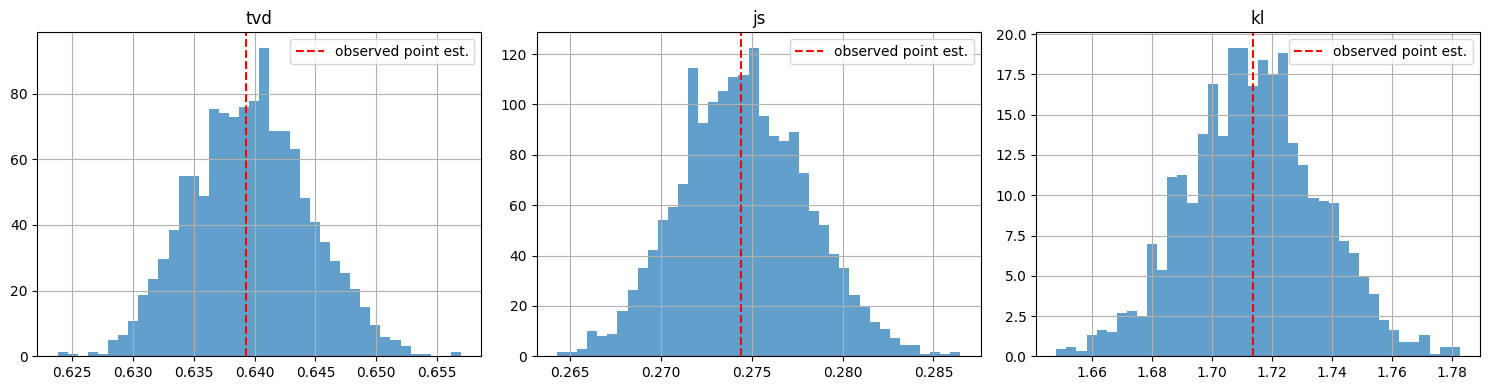

In [52]:
plot_bootstrap_histograms(res)